# App Reviews Analysis of Philippine Banks

---

This project seeks to analyze the performace of the iOS applications of the top 3 privately owned banks in the Philippines which are Banco De Oro (BDO), Bank of the Philippine Islands (BPI), and Metropolitan Bank & Trust Company (Metrobank) using Natural Language Processing or NLP.

The data is obtained from Apple App Store reviews. This project shows how you can derive insights generated by your users and make decisions based on these insights and data.

## Goal 4: Identify Topics in Reviews

---

When it comes to app reviews, users are always talking about something. When they leave a positive review they praise a part of that application, when they leave a negative review they always pinpoint their complaints about the app.

This task is focused to determine which aspects of the app users are reviewing about. We will focus on these five aspects of an application:


1. **Usability** - refers to how easy and intuitive it is for users to interact with the mobile application. A user-friendly app has a well-designed user interface (UI) and a logical flow that allows users to navigate and accomplish tasks without confusion. Usability testing helps identify and improve any usability issues by gathering feedback from real users.

2. **Functionality** - is the set of features and capabilities that the mobile application offers. It involves the core tasks and operations the app is designed to perform. An app with good functionality should meet the needs and expectations of its target audience and provide a seamless experience for users.

3. **Performance** - relates to how well the mobile application operates in terms of speed, responsiveness, and resource utilization. Users expect apps to load quickly, respond promptly to interactions, and not consume excessive battery or data. Performance testing helps identify and resolve bottlenecks or issues that could affect the app's speed and efficiency.

4. **Stability** - app stability is crucial for providing a reliable and consistent user experience. A stable mobile application should not crash, freeze, or produce unexpected errors or glitches during regular usage. Thorough testing, debugging, and monitoring are essential to maintain the stability of the app, especially as it evolves over time with updates and new features.

5. **Customer Support** - refers to the services and assistance provided to users who encounter problems, have questions, or need help while using the mobile application. This includes channels like email support, live chat, FAQs, and documentation. Effective customer support can enhance user satisfaction and loyalty, as users feel supported and valued by the app's developers.

These aspects are interconnected and together contribute to the overall success and user satisfaction of a mobile application. Developers and product managers need to pay close attention to these factors throughout the app's development, release, and ongoing maintenance to ensure that it meets the needs and expectations of its users.

In [1]:
import torch
from datasets import load_dataset
from transformers import pipeline

In [2]:
# Load your dataset (replace 'your_dataset' with the actual dataset)
# For a custom dataset: dataset = load_dataset('csv', data_files='path_to_your_file.csv')
dataset = load_dataset('csv', data_files='datasets/translated_df.csv')

Using custom data configuration default-411ef27fa3a5bd13


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

/usr/local/lib/python3.9/dist-packages/datasets/download/streaming_download_manager.py:695: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-411ef27fa3a5bd13/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Set up the classifier
classifier = pipeline("zero-shot-classification", 
                      model="facebook/bart-large-mnli", 
                      device=0 if torch.cuda.is_available() else -1)

In [4]:
def classify_text(examples):
    candidate_labels = ['usability', 'functionality', 'performance', 'stability', 'customer support']
    texts = examples['translated_review']  # This now expects a list of texts

    # Process texts in a batch
    results = classifier(texts, candidate_labels)
    
    # Extract predicted labels and their probabilities for each result in the batch
    predicted_labels = []
    probabilities = []
    for result in results:
        if 'labels' in result and len(result['labels']) > 0:
            predicted_labels.append(result['labels'][0])
            probabilities.append(result['scores'][0])
        else:
            predicted_labels.append(None)
            probabilities.append(None)

    return {'zs_label': predicted_labels, 'zs_prob': probabilities}

In [5]:
%%time

# Apply the classifier to the dataset
result_dataset = dataset.map(classify_text, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

CPU times: user 11min 54s, sys: 43.3 s, total: 12min 38s
Wall time: 12min 24s


In [6]:
# Determine the keys of the dataset, which we will use to convert back to a dataframe
print(list(result_dataset.keys()))

['train']


In [7]:
df_zeroshot = result_dataset['train'].to_pandas()
df_zeroshot.head()

,Unnamed: 0,date,review,rating,isEdited,userName,title,developerResponse,bank_app,review_language,review_language_prob,is_translated,translated_text,translated_review,zs_label,zs_prob
0,0,8/21/2023 22:42,I tried this one because of the notification i...,1.0,False,Dence07,Useless app,None,Banco De Oro,eng_Latn,0.999971,no,I tried this one because of the notification i...,I tried this one because of the notification i...,usability,0.372049
1,1,6/29/2023 6:55,I am quite disappointed with the BDO App’s lac...,1.0,False,Domansss,SMH,None,Banco De Oro,eng_Latn,0.999866,no,I am quite disappointed with the BDO App’s lac...,I am quite disappointed with the BDO App’s lac...,functionality,0.799804
2,2,9/18/2023 14:58,I have this app for a almost a month already a...,1.0,False,Je123DJ,Not User Friendly,None,Banco De Oro,eng_Latn,0.999952,no,I have this app for a almost a month already a...,I have this app for a almost a month already a...,functionality,0.607915
3,3,8/18/2023 8:18,What are these apps you keep developing? Do th...,1.0,False,Rieyuxel,Higher a UX Designer!,None,Banco De Oro,eng_Latn,0.999986,no,What are these apps you keep developing? Do th...,What are these apps you keep developing? Do th...,functionality,0.611326
4,4,2/3/2022 8:57,Since i have read the reviews and its not appe...,1.0,False,Abner61,TO MANY BDO APPS but useless.,None,Banco De Oro,eng_Latn,0.999955,no,Since i have read the reviews and its not appe...,Since i have read the reviews and its not appe...,usability,0.274798


Now the training has been finished, the reviews are now classified based on the categories we have described earlier, the following code provides a checking onto those labels that were generated as well as their probability that was caputred by the model.

In [8]:
df_zeroshot['zs_label'].value_counts()

functionality       1922
usability            858
performance          821
customer support      99
stability             75
Name: zs_label, dtype: int64

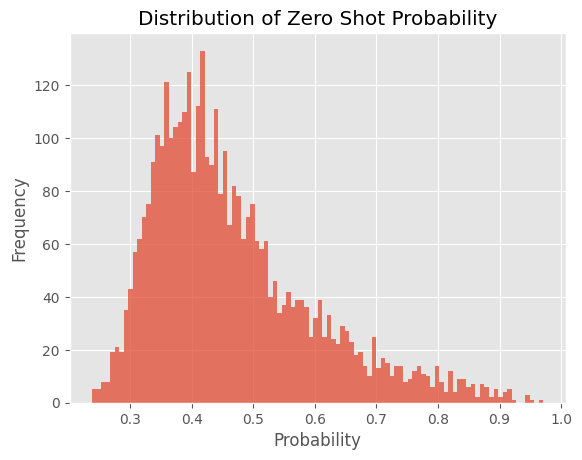

In [9]:
import matplotlib.pyplot as plt

# Set the style of the matplotlib plot
plt.style.use('ggplot')

# Plotting the histogram of the review_language_probability
plt.hist(df_zeroshot['zs_prob'], bins=100, alpha=0.75)

# Adding titles and labels
plt.title('Distribution of Zero Shot Probability')
plt.xlabel('Probability')
plt.ylabel('Frequency')

# Show the plot
plt.show()

Given that the zero-shot classification works by detecting the possible catagories it was not trained upon, the probabilities are spiked within the .35 to .45 range.

### Saving the new data

---

Now that we have categorized the reviews based on the different aspects of an application, let's save this now to use it as a data to capture the sentiment around the review in the next part.

In [10]:
df_zeroshot.to_csv('datasets/df_reviews_wcategories.csv')